**Import libraries**

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn3
from matplotlib.colors import to_rgb, to_hex
import seaborn as sns
import numpy as np

**This ipynb is used to process and analyze data from an experiment involving AAVrg and cFos in two conditions:**

"10 minutes familiar" (n=5) ***full_focus1*** 

"cagemate" (n=3) ***full_focus2***

The data is stored in an Excel file with two sheets: full_focus1 and full_focus2. This code performs data cleaning, mapping, and organization to prepare the data for further analysis.

In [16]:
# Load the Excel file
file_path = r"C:\Users\sjs93\Downloads\cell_counts_full (2).xlsx"
excel_file = pd.ExcelFile(file_path)

# Load both sheets into separate DataFrames
sheet1 = pd.read_excel(file_path, sheet_name='full_focus1')
sheet2 = pd.read_excel(file_path, sheet_name='full_focus2')

# Rename columns for consistency
sheet1.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]
sheet2.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]

# Drop the 'Threshold' column
sheet1 = sheet1.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])
sheet2 = sheet2.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])

sheet1['Slice'] = sheet1['Slice'].str.lower()
sheet2['Slice'] = sheet2['Slice'].str.lower()

# Define subject-specific mappings for Channel in full_focus1 = 10 mins fam condition 
subject_mappings_full_focus1 = {
    '2_1': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_2': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_3': {'gfp': 'NAc', 'mcherry': 'MD'},
    '1_2': {'gfp': 'MD', 'mcherry': 'NAc'},
    '1_3': {'gfp': 'MD', 'mcherry': 'NAc'}
}

# Define the default mapping for full_focus2 = cagemate condition 
default_mapping_full_focus2 = {'gfp': 'MD', 'mcherry': 'NAc'}


# Function to extract markers from Slice and create projector label
def create_projector(slice_value, subject, sheet_name):
    markers = []
    if 'cfos' in slice_value:
        markers.append('cfos')
    if 'gfp' in slice_value:
        markers.append('gfp')
    if 'mcherry' in slice_value:
        markers.append('mcherry')

    if sheet_name == 'full_focus1' and subject in subject_mappings_full_focus1:
        region_mapping = subject_mappings_full_focus1[subject]
    else:
        region_mapping = default_mapping_full_focus2

    combined_markers = []
    for marker in markers:
        if marker in ['gfp', 'mcherry']:
            region = region_mapping.get(marker, 'Unknown')
            combined_markers.append(region)
        else:
            combined_markers.append(marker)
    
    # Sort combined markers alphabetically to ensure consistent ordering
    combined_markers.sort()
    
    return '+'.join(combined_markers) + '+'

# Function to extract the subject number from the Slice column
def extract_subject(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 3:
        return parts[1] + '_' + parts[2]  # Assuming the subject number is in the 2nd and 3rd position
    return 'Unknown'  # In case the slice format is unexpected

# Function to extract the region information from the Slice column
def extract_region(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 4:
        return parts[3]  # Assuming the region information is in the 4th position
    return 'Unknown'  # In case the slice format is unexpected

# Process the data for both sheets
def process_data(df, sheet_name):
    df['Slice'] = df['Slice'].astype(str)
    df['Subject'] = df['Slice'].apply(extract_subject)  # Extract the subject number
    df['Region'] = df['Slice'].apply(extract_region)    # Extract the region information
    df['Projector'] = df.apply(lambda row: create_projector(row['Slice'], row['Subject'], sheet_name), axis=1)
    return df

# Apply the updated function to both sheets. sheet1_processed = 10 min fam, sheet2_processed = cagemate 
sheet1_processed = process_data(sheet1, 'full_focus1')
sheet2_processed = process_data(sheet2, 'full_focus2')

# Preprocessing Base Region Columns:
# The 'Region' column in both `sheet1_processed` and `sheet2_processed` DataFrames contains region strings.
# Assume each region string starts with an unnecessary prefix character (e.g., a code identifier),
# that you want to remove to make the 'Region' more readable or standardize formatting.

# The `.apply()` function here applies a lambda function to each element of the 'Region' column:
# `lambda x: x[1:]` - This lambda function takes each string `x` and slices it from the second character to the end.
# This effectively removes the first character of each string.

# The resulting series (after removal of the first character from each region string) 
# directly replaces the original 'Region' values in a new column called 'Base region':
sheet1_processed['Base region'] = sheet1_processed['Region'].apply(lambda x: x[1:])
sheet2_processed['Base region'] = sheet2_processed['Region'].apply(lambda x: x[1:])

# After execution, both DataFrames will have a new column 'Base region' 
# which contains the modified region strings with the first character removed.


Aggregating and Combining Data from Two Sheets

Objective:

This script aims to aggregate data based on specific categories from two distinct sheets, and it subsequently consolidates the results for a comprehensive comparison or analysis.

Steps and Explanation:

1. Grouping and Summing Data from sheet1_processed:

Group by Multiple Columns: Apply the .groupby() function on 'Projector', 'Subject', and 'Base region' which groups the data appropriately.

Aggregate: For each group, calculate the sum of the 'Count' column using ['Count'].sum(), which provides the total counts for each category.

Reset Index: The index is reset to ensure it's properly formatted and easy to read post-grouping.
Assign a New Column: We use .assign(sheet='full_focus1') to add a new column that indicates which sheet the data came from.

In [17]:
# Grouping data in sheet1:
# `groupby(['Projector', 'Subject', 'Base region'])` 
# This groups the data in the dataframe `sheet1_processed` by the columns 'Projector', 'Subject', and 'Base region'.

# `['Count'].sum()` 
#  For each group, it calculates the sum of the 'Count' column which represents the aggregated count.

# `reset_index()` - Resets the index of the DataFrame to the default integer index.

# `assign(sheet='full_focus1')` 
# Adds an additional column named 'sheet' which contains the sheet identifier 'full_focus1' for each row,
# helping to identify from which sheet (or focus) the data originated.
sheet1_grouped = sheet1_processed.groupby(['Projector', 'Subject', 'Base region'])['Count'].sum().reset_index().assign(sheet='full_focus1')

# Similar operations are performed on sheet2:
# Following the same steps as for sheet1 but results are marked with 'full_focus2'.
sheet2_grouped = sheet2_processed.groupby(['Projector', 'Subject', 'Base region'])['Count'].sum().reset_index().assign(sheet='full_focus2')

# Concatenating grouped data from sheet1 and sheet2:
# `pd.concat([...])` 
# This function is used to concatenate the data frames `sheet1_grouped` and `sheet2_grouped` along rows (default axis=0).
# As both DataFrames have the same structure, this will create a single DataFrame combining their rows.
projector_counts = pd.concat([sheet1_grouped, sheet2_grouped])

# Printing the aggregated counts:
# This final statement prints the concatenated DataFrame `projector_counts`, which includes total counts split by projector,
# subject, and base region, along with identifying which sheet each data row came from.
print("Total counts for each projector by sheet:")
print(projector_counts)

Total counts for each projector by sheet:
   Projector Subject Base region  Count        sheet
0        MD+     1_2         acc    694  full_focus1
1        MD+     1_2          il   1314  full_focus1
2        MD+     1_2          pl    299  full_focus1
3        MD+     1_3         acc    812  full_focus1
4        MD+     1_3          il    795  full_focus1
..       ...     ...         ...    ...          ...
58     cfos+     3_2          il    551  full_focus2
59     cfos+     3_2          pl    237  full_focus2
60     cfos+     3_3         acc    231  full_focus2
61     cfos+     3_3          il    442  full_focus2
62     cfos+     3_3          pl    482  full_focus2

[168 rows x 5 columns]


concat grouped data from sheet1_grouped and sheet2_grouped 

did soe crazy dic and mapping so sheet column has condtion names instead of sheet names



In [18]:
# Concatenating grouped data from sheet1 and sheet2
projector_counts = pd.concat([sheet1_grouped, sheet2_grouped])

# Replacing sheet names with actual conditions
condition_mapping = {
    'full_focus1': '10min_fam',
    'full_focus2': 'cagemate'
}
projector_counts['sheet'].replace(condition_mapping, inplace=True)

# Proceeding with any further analysis such as averaging the counts
projector_counts

,Projector,Subject,Base region,Count,sheet
0,MD+,1_2,acc,694,10min_fam
1,MD+,1_2,il,1314,10min_fam
2,MD+,1_2,pl,299,10min_fam
3,MD+,1_3,acc,812,10min_fam
4,MD+,1_3,il,795,10min_fam
...,...,...,...,...,...
58,cfos+,3_2,il,551,cagemate
59,cfos+,3_2,pl,237,cagemate
60,cfos+,3_3,acc,231,cagemate
61,cfos+,3_3,il,442,cagemate


**Calculating percent activation for the MD+ and NAc+ active cells in the ACC, PL, and IL**

This will help us to identify patterens in the population of each of the projectors and conditions 

projector_count df:

is  groupby (['Projector', 'Subject', 'Base region'])['Count'].sum()

it is adding the aACC, mACC, pACC for each subject so that each subject has a ACC, PL, and IL count 

colapsing down across AP axis

Can I use projector_counts dataframe to filter and calculate percent activation for MD+cfos+, NAc+cfos+, MD+NAc+cfos+
 
Calculate the percentage activation for each subject, brain region, and sheet 

The formula is: 


% Activation for active MD+ projectors (MD+cfos+) = MD+cfos+ cells **/**  Total MD+ cells (MD+cFos+ **+** MD+) × 100


% Activation (for NAc+cFos+) NAc+cFos+ cells **/**  Total NAc+ cells (NAc+cFos+ **+** NAc+) × 100

% Activation (for MD+NAc+cfos+) = MD+NAc+cfos+ cells /  Total MD+, NAc+ cells (MD+NAc+cFos+ **+** MD+ and NAc+) × 100

Group by brain region and sheet and then average the percentage activations across all subjects.

to calculate the percentage of activated cells (MD+cFos cells) out of the total cells labeled as MD+ in each region and sheet. This will give you the proportion of MD+ cells that are also cFos+, which indicates activation.

The numerator is the count of MD+cFos cells.
The denominator is the total count of MD+ cells (which includes MD+cFos cells + MD only cells).

Example:
subject 3_1 in ACC:

MD+cFos cells = 505
MD only cells = 551
Total MD+ cells = 505 + 551 = 1056
So, the percentage activation would be:

505 /
505
+
551
×
100
=
505 /
1056
×
100
≈
47.82
%

About 47.82% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_1)

Subject 3_2 in ACC:

MD+cFos cells = 172
MD only cells = 294
Total MD+ cells = 172 + 294 = 466
So, the percentage activation would be:

172 /
172
+
294
×
100
=
172 /
466
×
100
≈
36.90
%

About 36.90% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_2)

Subject 3_3 in ACC:

MD+cFos cells = 223
MD only cells = 237
Total MD+ cells = 223 + 237 = 460
So, the percentage activation would be:

223 /
223
+
237
×
100
=
223 /
460
×
100
≈
48.47
%

About 48.47% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_3)

Example Calculation:
For ACC in cagemate:

Subject 3_1: 
505 /
1056
×
100
≈
47.82
%

Subject 3_2: 
172 /
466
×
100
≈
36.90
%

Subject 3_3: 
223 /
460
×
100
≈
48.47
%

The average activation for ACC in cagemate would be:

Mean Percentage Activation
=
47.82
+
36.90
+
48.47 / 3 = 44.40 %


I need to calculate this for all subjects in each condtion (10 min fam and cagemate) because I want to then calculate the mean % activation across subjects for each region (ACC, PL, IL).

By calculating the mean percentage activation across subjects for each brain region and condition, I can see the overall trend in activation levels.


This code will process and analyze data to calculate the mean percentage activation for different cell types across various regions and conditions. 

1. Grouping and Summing Data

I group my data by Projector, Subject, Base region, and sheet. Then I sum up the Count values for each group. 

2. Creating a Pivot Table

Convert the grouped data into a pivot table

This table reorganizes my data, making it easier to calculate percentages

Each row in the pivot table represents a combination of Subject, Base region, and sheet

The columns represent different Projector types, and the values are the summed Count from the previous step

Any missing values are filled with 0.

In [19]:
#Explanation: groups the projector_counts DataFrame by the columns Projector, Subject, Base region, and sheet
#For each group, it sums up the Count values and then resets the index to convert the grouped result back into a DataFrame.

grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()

# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (pivot['MD+'] + pivot['NAc+'] + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Calculate the mean percentage activation per region and sheet
mean_activation = pivot.groupby(['Base region', 'sheet'])[['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']].mean().reset_index()

# Display the result
mean_activation

Projector,Base region,sheet,MD+cfos+_activation,NAc+cfos+_activation,MD+NAc+cfos+_activation
0,acc,10min_fam,40.285664,44.181408,25.646232
1,acc,cagemate,44.403367,39.866943,23.436364
2,il,10min_fam,44.170919,46.713336,27.317964
3,il,cagemate,43.559925,39.190249,21.495289
4,pl,10min_fam,41.839464,44.902586,26.068159
5,pl,cagemate,42.961815,37.917394,23.316798


Create markdown for this graph

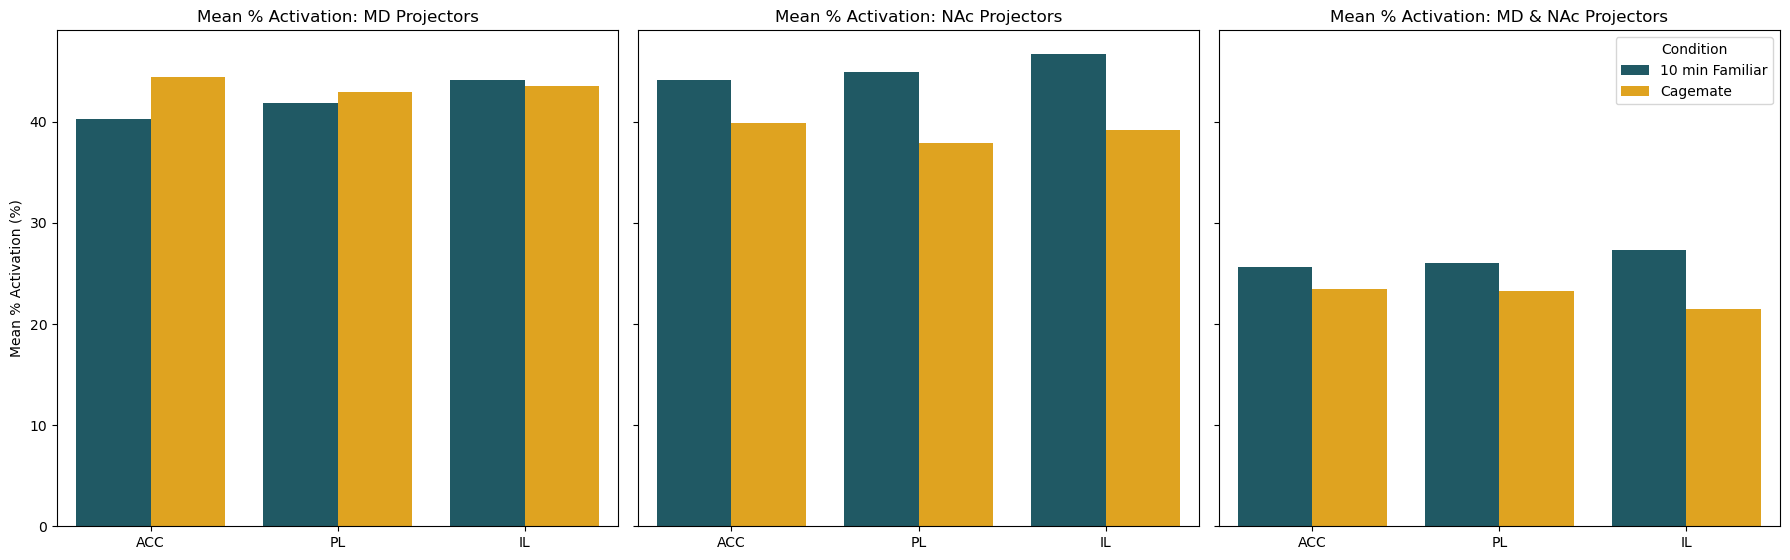

In [20]:
# Define a custom color palette
custom_palette = {'cagemate': '#FFAF00', '10min_fam': '#15616F'}

# Define new order for 'Base region' with exact case matching
category_order = ['acc', 'pl', 'il']

# Convert 'Base region' to ordered categorical type
mean_activation['Base region'] = pd.Categorical(mean_activation['Base region'], categories=category_order, ordered=True)

# Sort the DataFrame according to the new categorical column
mean_activation = mean_activation.sort_values('Base region')

# Replotting the data with the adjusted categorical settings
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.barplot(x='Base region', y='MD+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[0], palette=custom_palette)
axes[0].set_title('Mean % Activation: MD Projectors')
axes[0].set_ylabel('Mean % Activation (%)')

sns.barplot(x='Base region', y='NAc+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[1], palette=custom_palette)
axes[1].set_title('Mean % Activation: NAc Projectors')
axes[1].set_ylabel('')

sns.barplot(x='Base region', y='MD+NAc+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[2], palette=custom_palette)
axes[2].set_title('Mean % Activation: MD & NAc Projectors')
axes[2].set_ylabel('')

# Remove 'Base region' label from the x-axis of each subplot
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

# Customizing and removing legends as per previous layout
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles, ['10 min Familiar', 'Cagemate'], title='Condition')
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Update x-axis tick labels to be uppercase: using FixedLocator and FixedFormatter
for ax in axes:
    locs = ax.get_xticks()
    labels = [label.get_text().upper() for label in ax.get_xticklabels()]
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [32]:
# Assuming you have the projector_counts DataFrame ready with your data

# Group the DataFrame by the relevant columns and sum the counts
grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()

# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages without averaging
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100

# Calculate total counts for MD and NAc for MD+NAc+cfos+
total_md_nac = pivot['MD+'] + pivot['NAc+']
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (total_md_nac + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Display the result with individual subject activation percentages
print(pivot[['Subject', 'Base region', 'sheet', 
              'MD+cfos+_activation', 
              'NAc+cfos+_activation', 
              'MD+NAc+cfos+_activation']])


Projector Subject Base region      sheet  MD+cfos+_activation  \
0             1_2         acc  10min_fam            50.107836   
1             1_2          il  10min_fam            50.804942   
2             1_2          pl  10min_fam            50.983607   
3             1_3         acc  10min_fam            47.204161   
4             1_3          il  10min_fam            49.168798   
5             1_3          pl  10min_fam            46.111111   
6             2_1         acc  10min_fam            37.741369   
7             2_1          il  10min_fam            41.369710   
8             2_1          pl  10min_fam            44.141689   
9             2_2         acc  10min_fam            26.791621   
10            2_2          il  10min_fam            31.233457   
11            2_2          pl  10min_fam            30.593607   
12            2_3         acc  10min_fam            39.583333   
13            2_3          il  10min_fam            48.277689   
14            2_3        

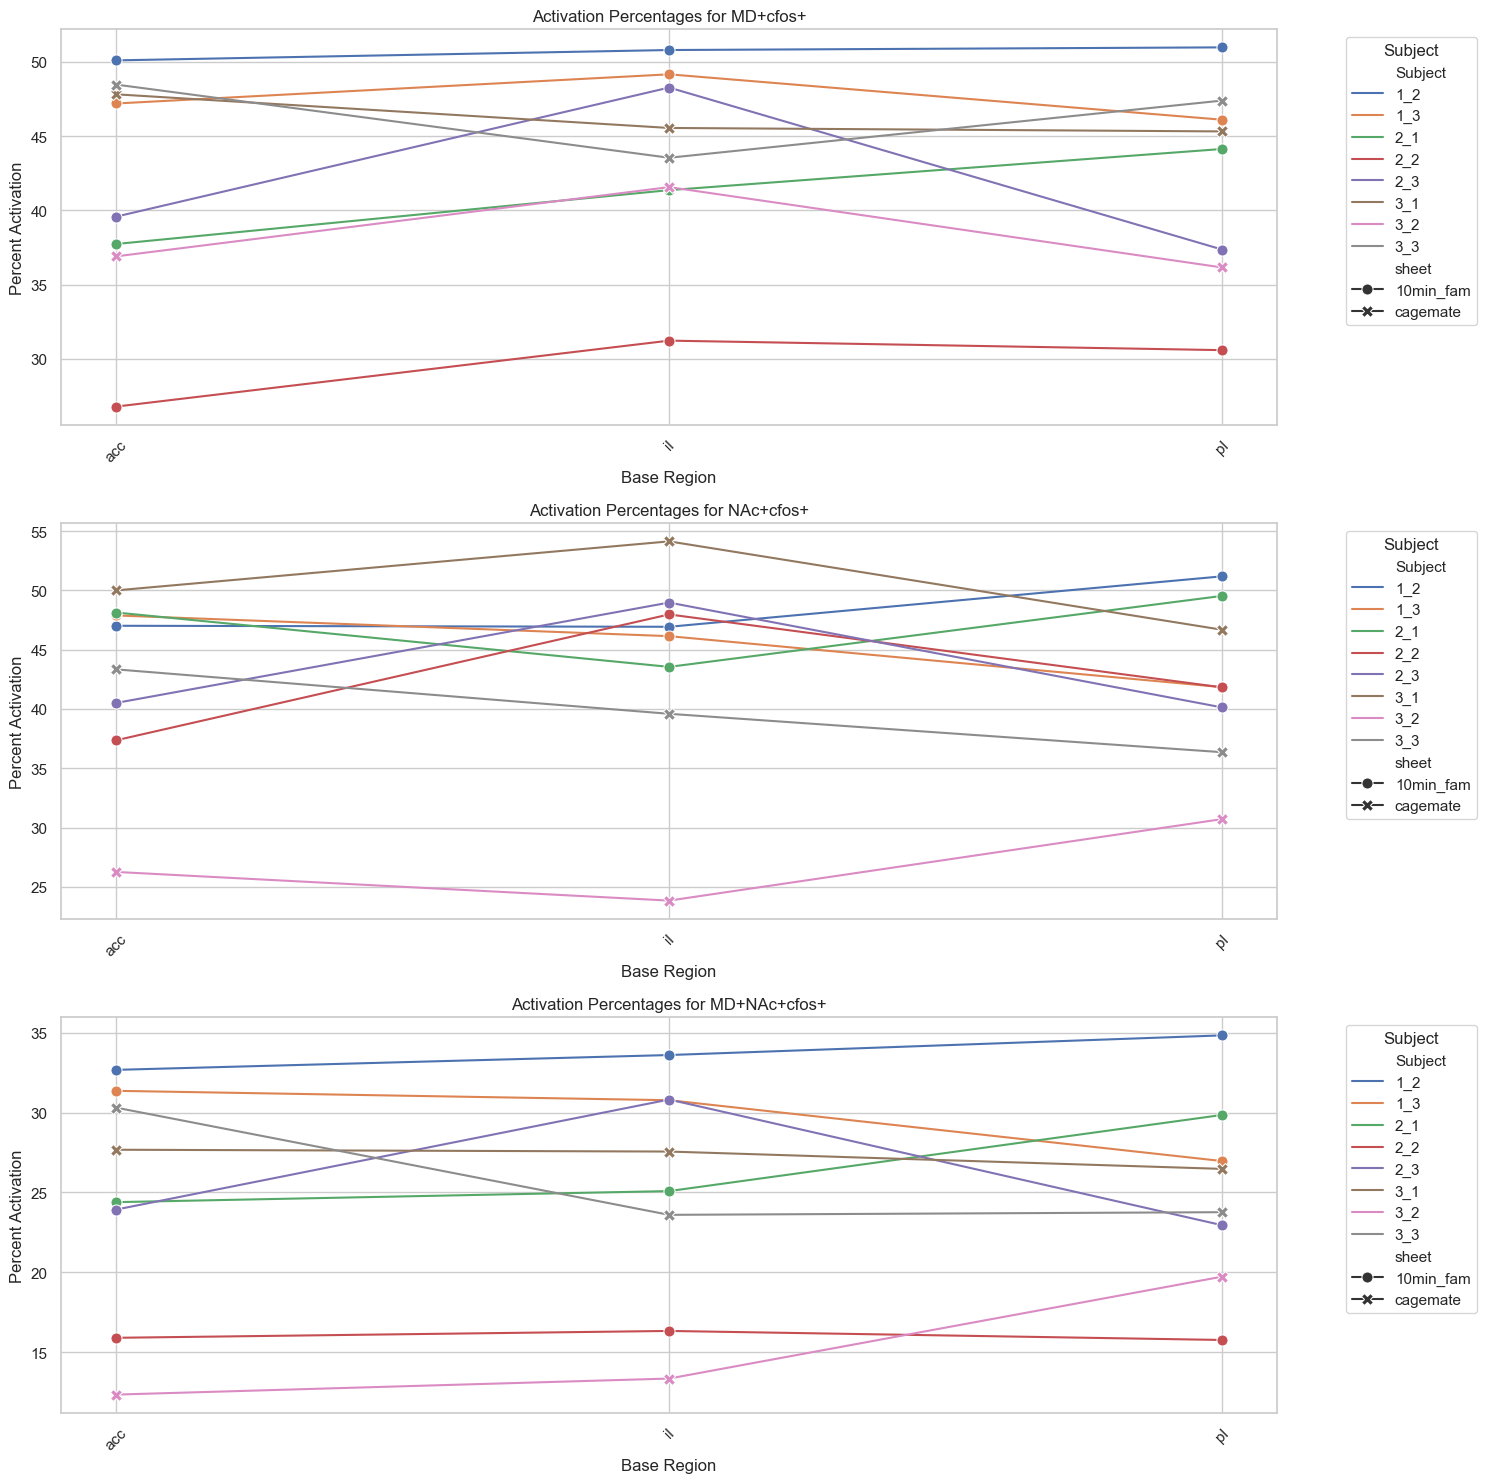

In [37]:
# Melt the DataFrame for easier plotting
melted = pivot.melt(id_vars=['Subject', 'Base region', 'sheet'], 
                     value_vars=['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation'],
                     var_name='Activation_Type', value_name='Percent_Activation')

# Create a color palette for different sheets
palette = {'10min_fam': 'blue', 'cagemate': 'orange'}

# Set up the plots
activation_types = ['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']
activation_labels = ['MD+cfos+', 'NAc+cfos+', 'MD+NAc+cfos+']

# Create separate plots for each activation type
plt.figure(figsize=(15, 15))

for i, activation in enumerate(activation_types):
    plt.subplot(3, 1, i + 1)  # Create a subplot for each activation type
    subset = melted[melted['Activation_Type'] == activation]
    
    # Create the line plot with Base Region on x-axis
    sns.lineplot(data=subset, x='Base region', y='Percent_Activation', hue='Subject',
                 palette='deep', markers=True, dashes=False, style='sheet', markersize=8)
    
    # Customizing the plot
    plt.title(f'Activation Percentages for {activation_labels[i]}')
    plt.xlabel('Base Region')
    plt.ylabel('Percent Activation')
    plt.xticks(rotation=45)
    plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


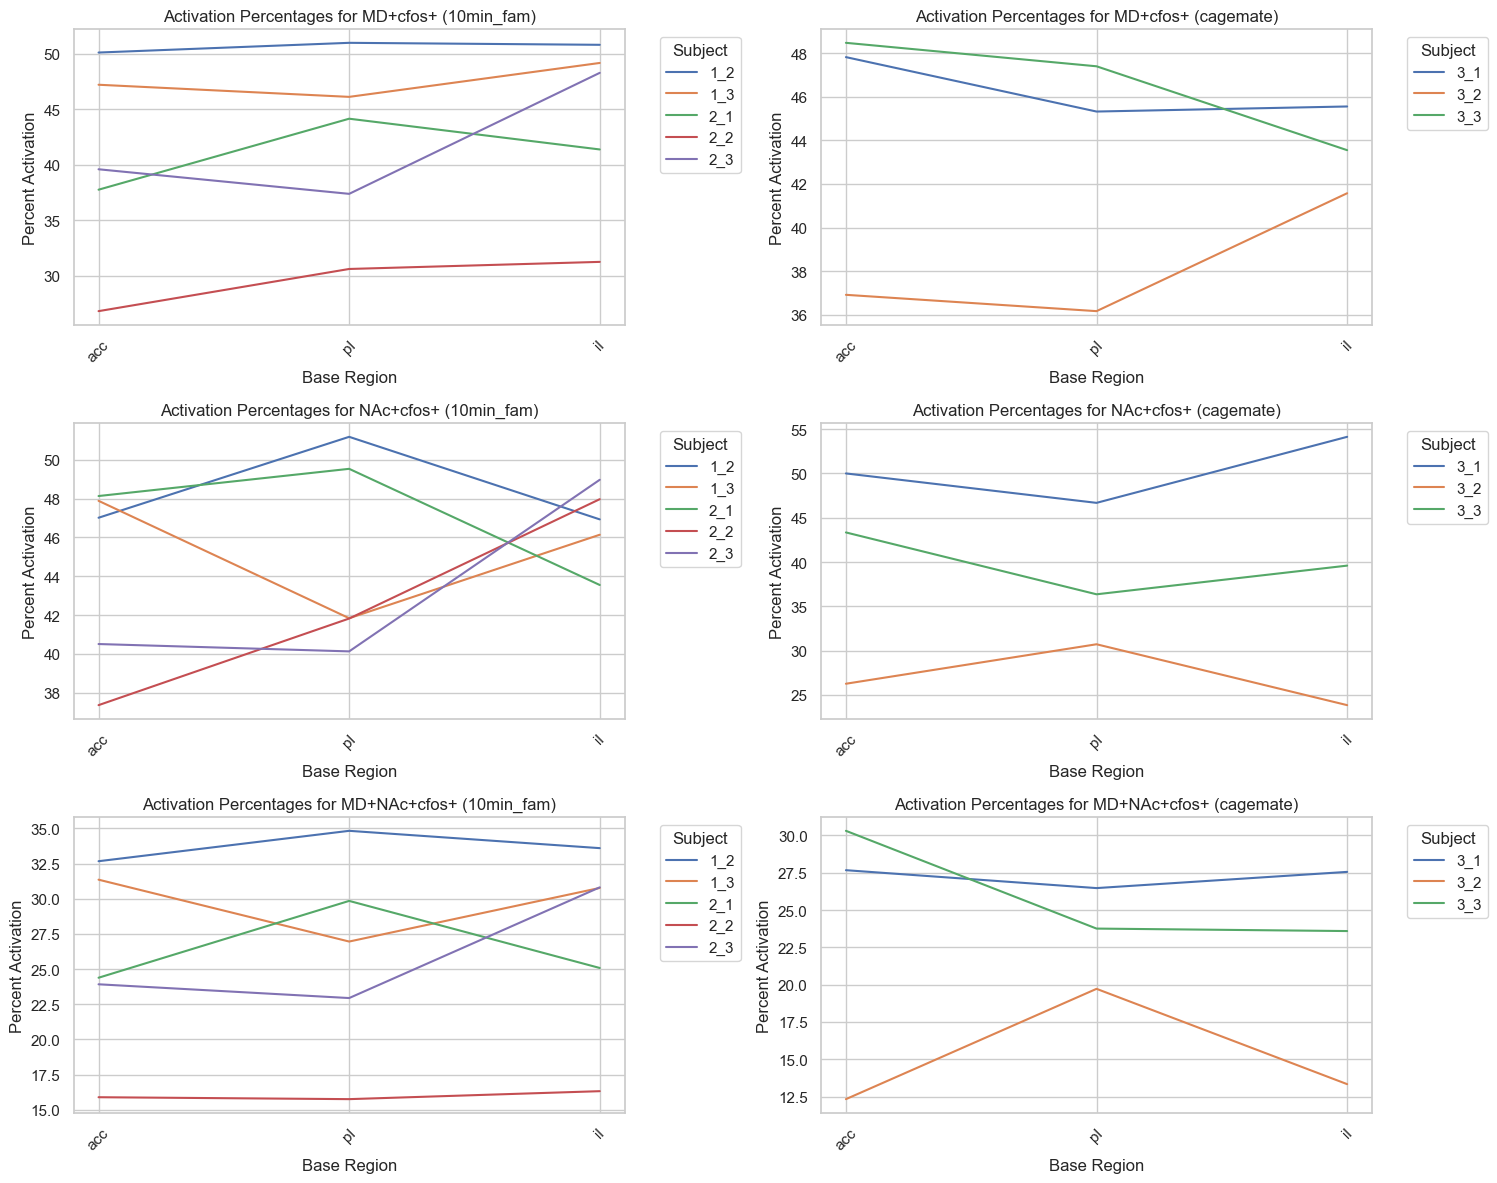

In [40]:
# Set the order of the base regions
base_region_order = ['acc', 'pl', 'il']

# Melt the DataFrame for easier plotting
melted = pivot.melt(id_vars=['Subject', 'Base region', 'sheet'], 
                     value_vars=['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation'],
                     var_name='Activation_Type', value_name='Percent_Activation')

# Ensure 'Base region' is treated as a categorical variable
melted['Base region'] = pd.Categorical(melted['Base region'], categories=base_region_order, ordered=True)

# Create a separate plot for each activation type and each sheet
activation_types = ['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']
activation_labels = ['MD+cfos+', 'NAc+cfos+', 'MD+NAc+cfos+']
sheets = ['10min_fam', 'cagemate']

# Set up the plots
plt.figure(figsize=(15, 12))

for i, activation in enumerate(activation_types):
    for j, sheet in enumerate(sheets):
        plt.subplot(3, 2, i * 2 + j + 1)  # Create a subplot for each activation type and sheet
        subset = melted[melted['Activation_Type'] == activation]
        subset = subset[subset['sheet'] == sheet]

        # Check if the subset is empty
        if subset.empty:
            plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', fontsize=15)
            plt.title(f'Activation Percentages for {activation_labels[i]} ({sheet})')
            plt.xlabel('Base Region')
            plt.ylabel('Percent Activation')
            plt.xticks(rotation=45)
            plt.grid(True)
            continue

        # Create the line plot with Base Region on x-axis
        sns.lineplot(data=subset, x='Base region', y='Percent_Activation', hue='Subject',
                     palette='deep', markers=True, dashes=False, markersize=8)

        # Customizing the plot
        plt.title(f'Activation Percentages for {activation_labels[i]} ({sheet})')
        plt.xlabel('Base Region')
        plt.ylabel('Percent Activation')
        plt.xticks(rotation=45)
        plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


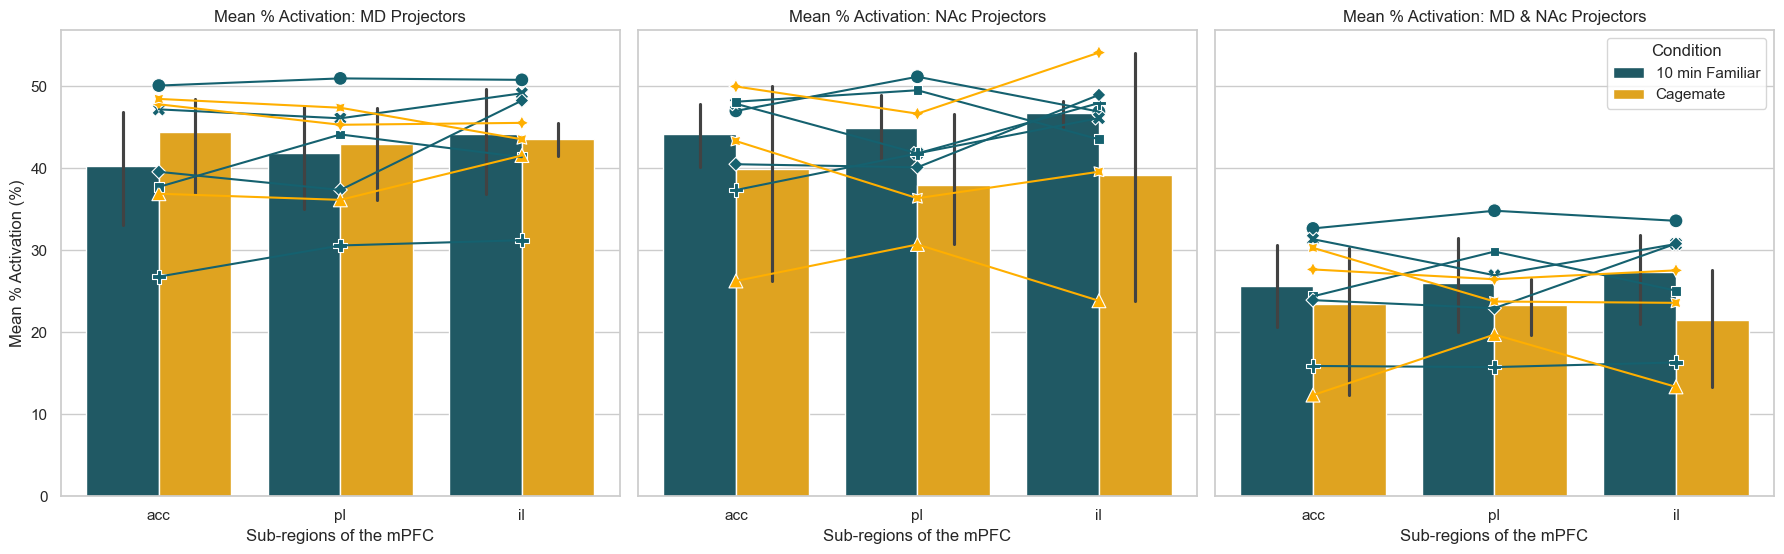

In [52]:
# Assuming you have your projector_counts DataFrame prepared
# Group the DataFrame by the relevant columns and sum the counts
grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()

# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages without averaging
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100

# Calculate total counts for MD and NAc for MD+NAc+cfos+
total_md_nac = pivot['MD+'] + pivot['NAc+']
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (total_md_nac + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Define a custom color palette
custom_palette = {'cagemate': '#FFAF00', '10min_fam': '#15616F'}

# Define new order for 'Base region'
category_order = ['acc', 'pl', 'il']

# Convert 'Base region' to ordered categorical type
pivot['Base region'] = pd.Categorical(pivot['Base region'], categories=category_order, ordered=True)

# Create bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Bar plots for each activation type
sns.barplot(x='Base region', y='MD+cfos+_activation', hue='sheet', data=pivot, ax=axes[0], palette=custom_palette)
axes[0].set_title('Mean % Activation: MD Projectors')
axes[0].set_ylabel('Mean % Activation (%)')

sns.barplot(x='Base region', y='NAc+cfos+_activation', hue='sheet', data=pivot, ax=axes[1], palette=custom_palette)
axes[1].set_title('Mean % Activation: NAc Projectors')
axes[1].set_ylabel('')

# Remove legends from the first two plots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

sns.barplot(x='Base region', y='MD+NAc+cfos+_activation', hue='sheet', data=pivot, ax=axes[2], palette=custom_palette)
axes[2].set_title('Mean % Activation: MD & NAc Projectors')
axes[2].set_ylabel('')

# Overlay individual subject data on top of bar plots with connecting lines
for i, activation in enumerate(['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']):
    # Create a scatter plot for individual subjects
    sns.scatterplot(x='Base region', y=activation, hue='sheet', style='Subject', 
                    data=pivot, palette=custom_palette, s=100, legend=False, ax=axes[i])
    
    # Overlay lines connecting subjects
    for subject in pivot['Subject'].unique():
        subject_data = pivot[pivot['Subject'] == subject]
        sns.lineplot(x='Base region', y=activation, data=subject_data, ax=axes[i], 
                     hue='sheet', palette=custom_palette, legend=False)

# Remove 'Base region' label from the x-axis of each subplot
for ax in axes:
    ax.set_xlabel('Sub-regions of the mPFC')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Use integer labels

# Customizing the legend for the last subplot
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles, ['10 min Familiar', 'Cagemate'], title='Condition')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

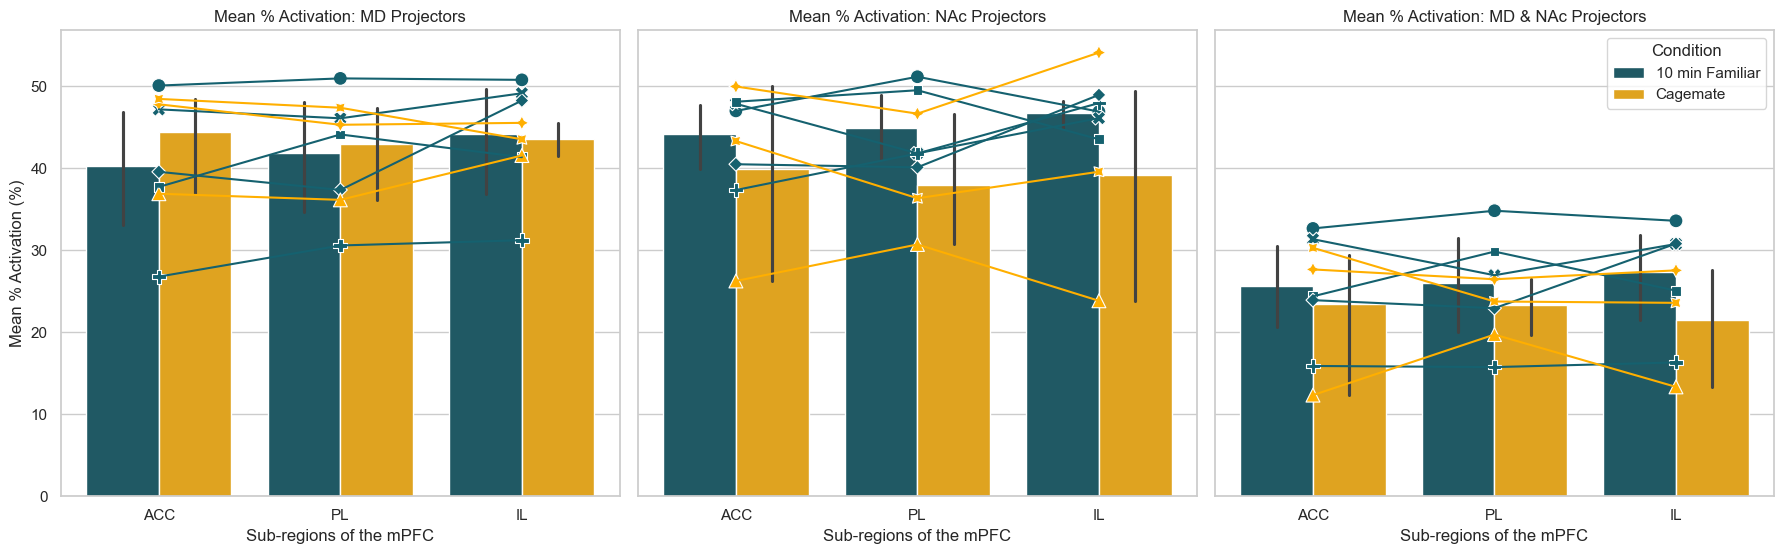

In [57]:
# Assuming you have your projector_counts DataFrame prepared
# Group the DataFrame by the relevant columns and sum the counts
grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()

# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages without averaging
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100

# Calculate total counts for MD and NAc for MD+NAc+cfos+
total_md_nac = pivot['MD+'] + pivot['NAc+']
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (total_md_nac + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Define a custom color palette
custom_palette = {'cagemate': '#FFAF00', '10min_fam': '#15616F'}

# Define new order for 'Base region'
category_order = ['ACC', 'PL', 'IL']  # Use uppercase for labels

# Convert 'Base region' to ordered categorical type with uppercase labels
pivot['Base region'] = pd.Categorical(pivot['Base region'].str.upper(), categories=category_order, ordered=True)

# Create bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Bar plots for each activation type
sns.barplot(x='Base region', y='MD+cfos+_activation', hue='sheet', data=pivot, ax=axes[0], palette=custom_palette)
axes[0].set_title('Mean % Activation: MD Projectors')
axes[0].set_ylabel('Mean % Activation (%)')

sns.barplot(x='Base region', y='NAc+cfos+_activation', hue='sheet', data=pivot, ax=axes[1], palette=custom_palette)
axes[1].set_title('Mean % Activation: NAc Projectors')
axes[1].set_ylabel('')

# Remove legends from the first two plots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

sns.barplot(x='Base region', y='MD+NAc+cfos+_activation', hue='sheet', data=pivot, ax=axes[2], palette=custom_palette)
axes[2].set_title('Mean % Activation: MD & NAc Projectors')
axes[2].set_ylabel('')

# Overlay individual subject data on top of bar plots with connecting lines
for i, activation in enumerate(['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']):
    # Create a scatter plot for individual subjects
    sns.scatterplot(x='Base region', y=activation, hue='sheet', style='Subject', 
                    data=pivot, palette=custom_palette, s=100, legend=False, ax=axes[i])
    
    # Overlay lines connecting subjects
    for subject in pivot['Subject'].unique():
        subject_data = pivot[pivot['Subject'] == subject]
        sns.lineplot(x='Base region', y=activation, data=subject_data, ax=axes[i], 
                     hue='sheet', palette=custom_palette, legend=False)

# Remove 'Base region' label from the x-axis of each subplot
for ax in axes:
    ax.set_xlabel('Sub-regions of the mPFC')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Use integer labels

# Customizing the legend for the last subplot
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles, ['10 min Familiar', 'Cagemate'], title='Condition')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\sjs93\AppData\Local\Temp\ipykernel_39520\1431454319.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


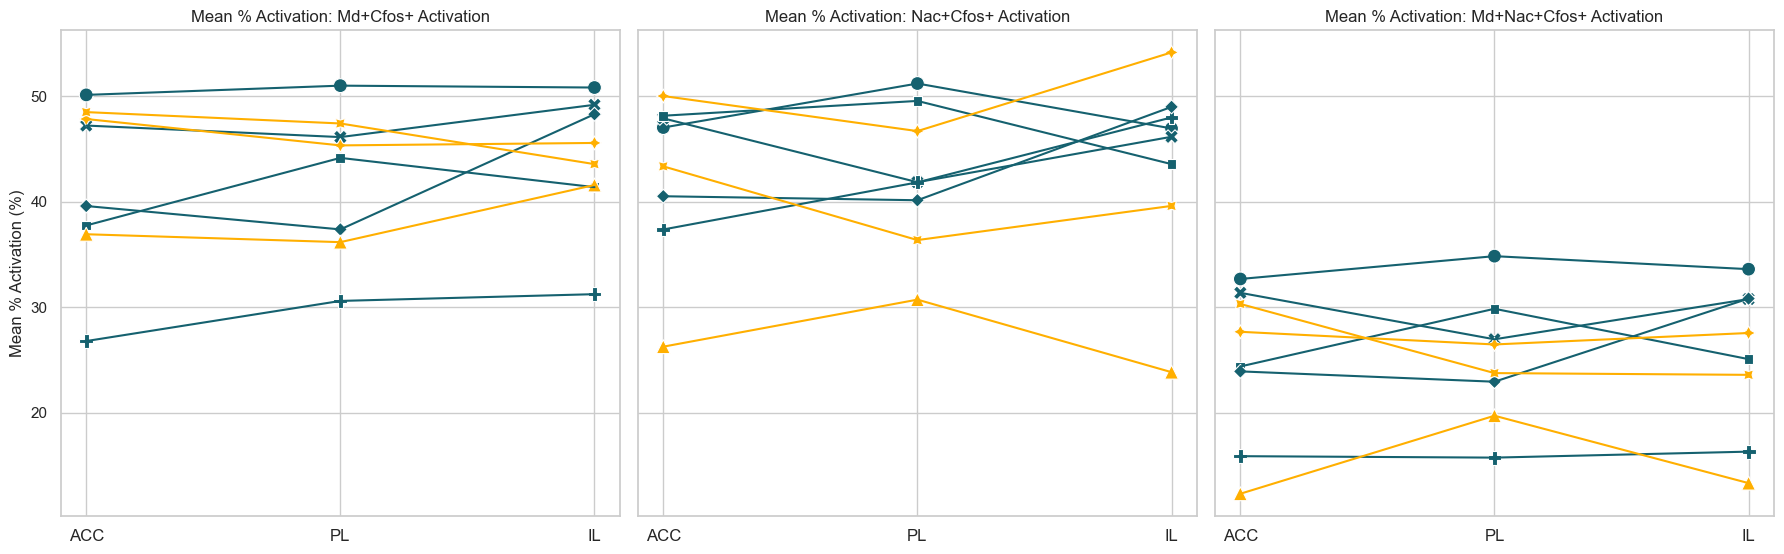

In [60]:
# Assuming you have your projector_counts DataFrame prepared
# Group the DataFrame by the relevant columns and sum the counts
grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()

# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages without averaging
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100

# Calculate total counts for MD and NAc for MD+NAc+cfos+
total_md_nac = pivot['MD+'] + pivot['NAc+']
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (total_md_nac + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Define a custom color palette for conditions
custom_palette = {'cagemate': '#FFAF00', '10min_fam': '#15616F'}

# Define new order for 'Base region'
category_order = ['ACC', 'PL', 'IL']  # Change to uppercase

# Convert 'Base region' to ordered categorical type
pivot['Base region'] = pd.Categorical(pivot['Base region'].str.upper(), categories=category_order, ordered=True)

# Create a figure for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Overlay individual subject data on top of line plots
for i, activation in enumerate(['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']):
    # Create a scatter plot for individual subjects
    sns.scatterplot(x='Base region', y=activation, hue='sheet', style='Subject', 
                    data=pivot, palette=custom_palette, s=100, legend=False, ax=axes[i])
    
    # Overlay lines connecting subjects
    for subject in pivot['Subject'].unique():
        subject_data = pivot[pivot['Subject'] == subject]
        sns.lineplot(x='Base region', y=activation, data=subject_data, ax=axes[i], 
                     hue='sheet', palette=custom_palette, legend=False)

    # Set titles for each subplot
    axes[i].set_title(f'Mean % Activation: {activation.replace("_", " ").title()}')
    axes[i].set_ylabel('Mean % Activation (%)')
    
    # Remove x-axis label
    axes[i].set_xlabel('')
    axes[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Use integer labels

# Remove legends from all subplots (safely)
for ax in axes:
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

# Set x-tick labels to be uppercase
for ax in axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()